##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Tensorflow lite 로 모델 불러와서 실행하기 from 첫 번째 신경망 훈련하기: 기초적인 분류 문제

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />TensorFlow.org에서 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />깃허브(GitHub) 소스 보기</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/keras/classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

:TFLITE

':TFLITE' 이 앞에 붙은 셀은 기존 원문에 추가된 내용입니다.

원래 튜토리얼에서는 운동화나 셔츠 같은 옷 이미지를 분류하는 신경망 모델을 훈련했습니다. 모델을 훈련할 때는 텐서플로 모델을 만들고 훈련할 수 있는 고수준 API인 [tf.keras](https://www.tensorflow.org/guide/keras)를 사용했습니다.
그러나 튜토리얼처럼 모델을 훈련하고 적용하기 위해서는 최소 AVX 또는 SSE4 등 고급 명령어를 사용하는 CPU 가 필요합니다. IoT 장비에 사용하기는 비싸고 높은 전력을 사용하기에 적합하지 않습니다.

만약 작은 카메라 정도를 가진 IoT 장비에서 훈련된 모델을 사용할 수 있게 하려면 어떻게 할까요? Tensorflow lite 를 통해 기존 모델을 불러오고 원래 튜토리얼의 훈련 부분을 제외한 예측 파트를 실행해보겠습니다.

In [3]:
!pip install -q matplotlib

You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [4]:
# 이 장비에서는 tensorflow 를 import 할 수 없다고 가정합니다.
# Tensorflow lite 를 대신 가져옵니다.
import tflite_runtime.interpreter as tflite
import platform

# 헬퍼(helper) 라이브러리를 임포트합니다
import numpy as np
import matplotlib.pyplot as plt

EDGETPU_SHARED_LIB = {
  'Linux': 'libedgetpu.so.1',
  'Darwin': 'libedgetpu.1.dylib',
  'Windows': 'edgetpu.dll'
}[platform.system()]

## 패션 MNIST 데이터셋 임포트하기

10개의 범주(category)와 70,000개의 흑백 이미지로 구성된 [패션 MNIST](https://github.com/zalandoresearch/fashion-mnist) 데이터셋을 사용하겠습니다. 이미지는 해상도(28x28 픽셀)가 낮고 다음처럼 개별 옷 품목을 나타냅니다:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>그림 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">패션-MNIST 샘플</a> (Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

패션 MNIST는 컴퓨터 비전 분야의 "Hello, World" 프로그램격인 고전 [MNIST](http://yann.lecun.com/exdb/mnist/) 데이터셋을 대신해서 자주 사용됩니다. MNIST 데이터셋은 손글씨 숫자(0, 1, 2 등)의 이미지로 이루어져 있습니다. 여기서 사용하려는 옷 이미지와 동일한 포맷입니다.

패션 MNIST는 일반적인 MNIST 보다 조금 더 어려운 문제이고 다양한 예제를 만들기 위해 선택했습니다. 두 데이터셋은 비교적 작기 때문에 알고리즘의 작동 여부를 확인하기 위해 사용되곤 합니다. 코드를 테스트하고 디버깅하는 용도로 좋습니다.

네트워크를 훈련하는데 60,000개의 이미지를 사용합니다. 그다음 네트워크가 얼마나 정확하게 이미지를 분류하는지 10,000개의 이미지로 평가하겠습니다. 패션 MNIST 데이터셋은 텐서플로에서 바로 임포트하여 적재할 수 있습니다:

:TFLITE

fashion_mnist 데이터셋을 불러올 때 keras API 를 사용했습니다. 그러나 keras 는 tensorflow 에 의존적이기 때문에 이 시나리오에서는 사용할 수 없습니다. 대신 미리 저장된 npy (numpy array 저장형식) 파일로부터 데이터를 불러옵니다.

데이터를 불러오고 '데이터 탐색' 파트의 내용이 원본 튜토리얼과 동일한지 확인해봅시다.

In [5]:
train_images = np.load('datasets/train_images.npy')
train_labels = np.load('datasets/train_labels.npy')
test_images = np.load('datasets/test_images.npy')
test_labels = np.load('datasets/test_labels.npy')

load_data() 함수를 호출하면 네 개의 넘파이(NumPy) 배열이 반환됩니다:

* `train_images`와 `train_labels` 배열은 모델 학습에 사용되는 *훈련 세트*입니다.
* `test_images`와 `test_labels` 배열은 모델 테스트에 사용되는 *테스트 세트*입니다.

이미지는 28x28 크기의 넘파이 배열이고 픽셀 값은 0과 255 사이입니다. *레이블*(label)은 0에서 9까지의 정수 배열입니다. 이 값은 이미지에 있는 옷의 *클래스*(class)를 나타냅니다:

<table>
  <tr>
    <th>레이블</th>
    <th>클래스</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

각 이미지는 하나의 레이블에 매핑되어 있습니다. 데이터셋에 *클래스 이름*이 들어있지 않기 때문에 나중에 이미지를 출력할 때 사용하기 위해 별도의 변수를 만들어 저장합니다:

In [6]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

## 데이터 탐색

모델을 훈련하기 전에 데이터셋 구조를 살펴보죠. 다음 코드는 훈련 세트에 60,000개의 이미지가 있다는 것을 보여줍니다. 각 이미지는 28x28 픽셀로 표현됩니다:

In [7]:
train_images.shape

(60000, 28, 28)

비슷하게 훈련 세트에는 60,000개의 레이블이 있습니다:

In [8]:
len(train_labels)

60000

각 레이블은 0과 9사이의 정수입니다:

In [9]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

테스트 세트에는 10,000개의 이미지가 있습니다. 이 이미지도 28x28 픽셀로 표현됩니다:

In [10]:
test_images.shape

(10000, 28, 28)

테스트 세트는 10,000개의 이미지에 대한 레이블을 가지고 있습니다:

In [11]:
len(test_labels)

10000

## 데이터 전처리

네트워크를 훈련하기 전에 데이터를 전처리해야 합니다. 훈련 세트에 있는 첫 번째 이미지를 보면 픽셀 값의 범위가 0~255 사이라는 것을 알 수 있습니다:

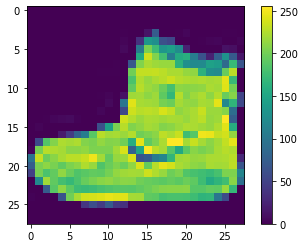

In [12]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

신경망 모델에 주입하기 전에 이 값의 범위를 0~1 사이로 조정하겠습니다. 이렇게 하려면 255로 나누어야 합니다. *훈련 세트*와 *테스트 세트*를 동일한 방식으로 전처리하는 것이 중요합니다:

In [13]:
train_images = train_images / 255.0

test_images = test_images / 255.0

*훈련 세트*에서 처음 25개 이미지와 그 아래 클래스 이름을 출력해 보죠. 데이터 포맷이 올바른지 확인하고 네트워크 구성과 훈련할 준비를 마칩니다.

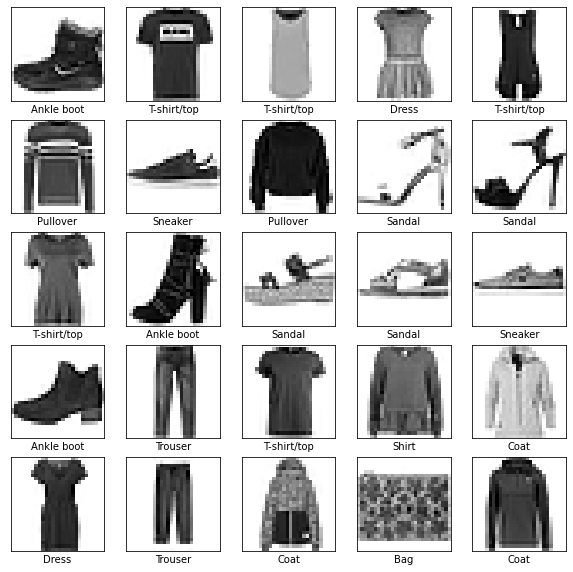

In [14]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

## :TFLITE 예측 불러오기

훈련된 모델을 불러와서 원본 튜토리얼의 '예측 만들기'를 재현해봅시다. 이 디바이스에서 모델이 훈련된 적은 없지만 다른 디바이스에서 훈련되었다면 똑같은 결과가 나와야 합니다.

In [15]:
def make_interpreter(model_file):
  model_file, *device = model_file.split('@')
  return tflite.Interpreter(
      model_path=model_file,
      experimental_delegates=[
          tflite.load_delegate(EDGETPU_SHARED_LIB,
                               {'device': device[0]} if device else {})
      ])

:TFLITE 모델 파일로부터 interpreter 를 만들어주는 함수입니다.

:TFLITE 이제 인터프리터를 통해 모델을 불러오도록 합시다. 아래의 셀을 실행하면 .tflite 로 형태로 저장되어있는 이미 훈련된 모델 파일을 불러와서 예측을 실행할 수 있습니다.

만약 Google Coral Accelerator 가 없거나 USB 연결이 비정상적일 경우 아래의 셀은 'ValueError: Failed to load delegate from libedgetpu.so.1' 와 유사한 에러를 발생하면서 동작하지 않습니다.

장치가 변경되었으면 런타임이 재시작되어야 할 수도 있습니다. 만약 런타임이 리셋되었다면 (다음 셀을 실행했을 때 수행 번호가 리셋) 커널을 종료하고 이 셀까지 처음부터 다시 실행하세요.

In [16]:
interpreter = make_interpreter("./model.tflite")
interpreter.allocate_tensors()
interpreter.get_output_details()[0]['shape']

array([ 1, 10], dtype=int32)

:TFLITE 파일로 불러들인 모델의 입력값과 출력값을 살펴볼 수 있습니다.

In [17]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

[{'name': 'flatten_input', 'index': 0, 'shape': array([ 1, 28, 28], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}]
[{'name': 'Identity', 'index': 9, 'shape': array([ 1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}}]


:TFLITE 원본 튜토리얼의 predictions 를 만들어봅시다. 우선 이미지 하나에 대한 prediction 을 출력하는 함수입니다.:TFLITE 

In [18]:
def predict_single(test_image):    
    input_shape = input_details[0]['shape']
    input_data = np.array(np.array([test_image]), dtype=np.float32)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data[0]

In [19]:
predictions = np.array(list(map(predict_single, test_images)))

:TFLITE <code>predictions</code> 변수를 만들었습니다! 원본 튜토리얼의 <code>predictions</code> 와 동일하게 작동하는지 확인해보세요. (훈련된 값은 훈련될 때마다 다를 수 있음.)

In [20]:
predictions[0]

array([5.8420005e-07, 3.8175546e-08, 4.4047777e-08, 7.8834182e-07,
       2.0882913e-08, 4.9257945e-02, 1.2914209e-06, 8.4851392e-02,
       4.1384486e-05, 8.6584657e-01], dtype=float32)

이 예측은 10개의 숫자 배열로 나타납니다. 이 값은 10개의 옷 품목에 상응하는 모델의 신뢰도(confidence)를 나타냅니다. 가장 높은 신뢰도를 가진 레이블을 찾아보죠:

In [21]:
np.argmax(predictions[0])

9

모델은 이 이미지가 앵클 부츠(`class_name[9]`)라고 가장 확신하고 있습니다. 이 값이 맞는지 테스트 레이블을 확인해 보죠:

In [22]:
test_labels[0]

9

10개 클래스에 대한 예측을 모두 그래프로 표현해 보겠습니다:

In [23]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

0번째 원소의 이미지, 예측, 신뢰도 점수 배열을 확인해 보겠습니다.

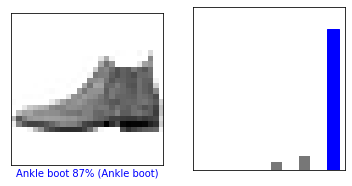

In [24]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

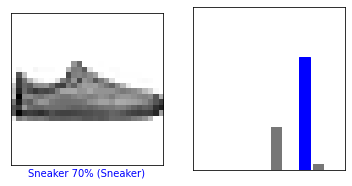

In [25]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)
plt.show()

몇 개의 이미지의 예측을 출력해 보죠. 올바르게 예측된 레이블은 파란색이고 잘못 예측된 레이블은 빨강색입니다. 숫자는 예측 레이블의 신뢰도 퍼센트(100점 만점)입니다. 신뢰도 점수가 높을 때도 잘못 예측할 수 있습니다.

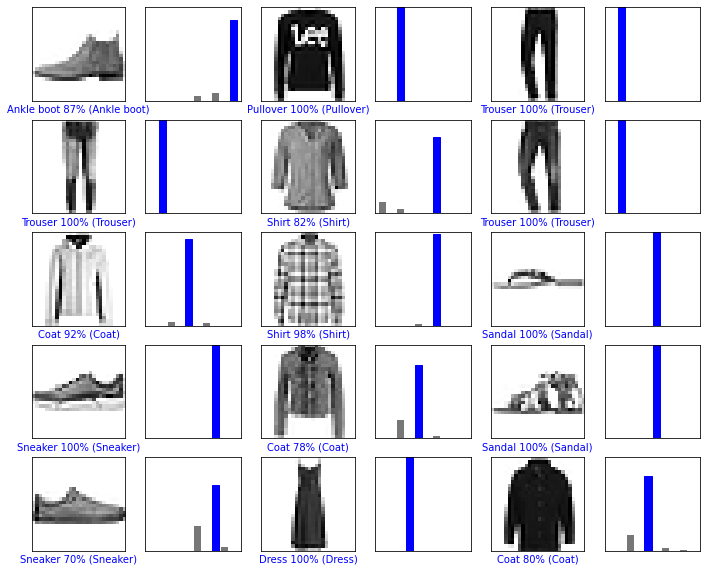

In [26]:
# 처음 X 개의 테스트 이미지와 예측 레이블, 진짜 레이블을 출력합니다
# 올바른 예측은 파랑색으로 잘못된 예측은 빨강색으로 나타냅니다
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)
plt.show()

마지막으로 훈련된 모델을 사용하여 한 이미지에 대한 예측을 만듭니다.

In [27]:
# 테스트 세트에서 이미지 하나를 선택합니다
img = test_images[0]

print(img.shape)

(28, 28)


`tf.keras` 모델은 한 번에 샘플의 묶음 또는 *배치*(batch)로 예측을 만드는데 최적화되어 있습니다. 하나의 이미지를 사용할 때에도 2차원 배열로 만들어야 합니다:

In [28]:
# 이미지 하나만 사용할 때도 배치에 추가합니다
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [29]:
predictions[0]

array([5.8420005e-07, 3.8175546e-08, 4.4047777e-08, 7.8834182e-07,
       2.0882913e-08, 4.9257945e-02, 1.2914209e-06, 8.4851392e-02,
       4.1384486e-05, 8.6584657e-01], dtype=float32)